# CNN with MNIST dataset

In this notebook, we will employ convolutional neural network (CNN) to classify handwriting digits with the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The library `torchvision` comes with the MNIST dataset, and we can simply download the dataset with the following codes.

In [2]:
T = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=T)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=T)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

The data will be downloaded under the folder `data`. We utilize the `DataLoader` to divide the data into mini-batches of size 4. And of course, the images were converted to `torch` tensors. To see how the images can be loaded from these dataloaders, here is an example:

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

The variable `images` will contain four images and `labels` will contain their labels. They are both `torch` tensors.

In [4]:
type(images)

torch.Tensor

In [5]:
images.shape

torch.Size([4, 1, 28, 28])

In [6]:
labels

tensor([8, 8, 3, 6])

In our dataset, every image has 28 x 28 pixels. To get the sizes of our training set and testing set, we can excute the following codes:

In [7]:
len(trainloader) * 4

60000

In [8]:
len(testloader) * 4

10000

Before we get to the deep learning part, let's plot some of our images. In order to use `matplotlib.pyplot` for plotting, the `torch` tensors need to be converted to `numpy` arrays first.

In [9]:
images_numpy = images.numpy()
labels_numpy = labels.numpy()

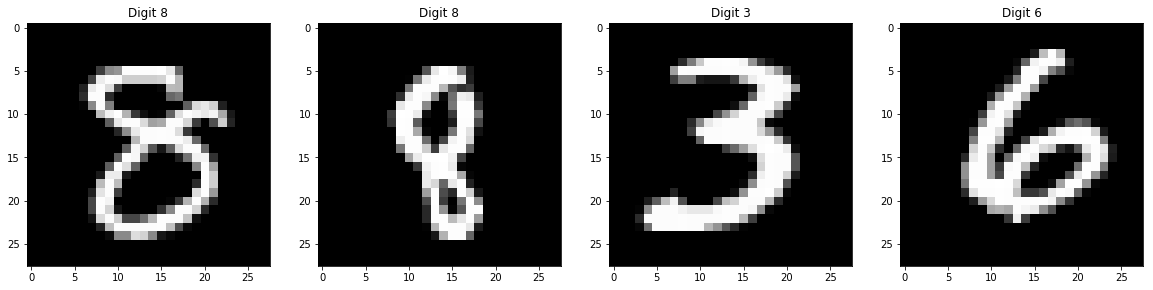

In [10]:
plt.figure(figsize=(20, 10))

for i in range(4):
    plt.subplot(1, 4, i+1)
    title = 'Digit ' + str(labels_numpy[i])
    plt.title(title)
    plt.imshow(images_numpy[i, 0, :, :], cmap='gray');

Now, we are ready to build our CNN. For illustration, I first make an example network to see how an image (or rather, a batch of images) will be processed in our network. We will ask our network to print out the size of the tensor at every step.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        print(x.shape)
        
        x = self.conv1(x)
        print(x.shape)
        
        x = self.pool(F.relu(x))
        print(x.shape)
        
        x = self.conv2(x)
        print(x.shape)
        
        x = self.pool(F.relu(x))
        print(x.shape)
        
        x = x.view(-1, 16 * 4 * 4)
        print(x.shape)
        
        x = F.relu(self.fc1(x))
        print(x.shape)
        
        x = F.relu(self.fc2(x))
        print(x.shape)
        
        x = self.fc3(x)
        print(x.shape)
        return x


net = Net()

Let see what happen if we apply this network on a batch of images:

In [12]:
net(images)

torch.Size([4, 1, 28, 28])
torch.Size([4, 6, 24, 24])
torch.Size([4, 6, 12, 12])
torch.Size([4, 16, 8, 8])
torch.Size([4, 16, 4, 4])
torch.Size([4, 256])
torch.Size([4, 120])
torch.Size([4, 84])
torch.Size([4, 10])


tensor([[ 0.0477, -0.0111,  0.0448, -0.0652,  0.0822, -0.0935, -0.0395, -0.0634,
          0.0578, -0.0135],
        [ 0.0458, -0.0218,  0.0483, -0.0637,  0.0921, -0.0820, -0.0400, -0.0736,
          0.0605, -0.0048],
        [ 0.0431, -0.0095,  0.0456, -0.0680,  0.0880, -0.0807, -0.0329, -0.0737,
          0.0517, -0.0057],
        [ 0.0505, -0.0161,  0.0361, -0.0744,  0.0918, -0.0855, -0.0374, -0.0663,
          0.0635, -0.0045]], grad_fn=<AddmmBackward>)

Our batch of images takes the shape (4, 1, 28, 28) since we are inputting 4 images at once. The first layer is given by 6 5x5 filters, and so the shape of our data becomes (4, 6, 24, 24). After the 2x2 max pooling, it is (4, 6, 12, 12).

The next layer is a little bit tricky. We input 6 channels of 12x12 images and the layer would output 16 channels of 8x8 images. When calculating these 16 outpts, the network will apply a separate filter for each of the 6 input channels, and then sum them together. As you can probably guess, there are 16x6x5x5 parameters involved here (excluding the bias term).

After the last max pooling, each image has become a tensor of size (16, 4, 4). This is very importance since we need to manually set 16x4x4 = 256 as the input dimension of our first fully connected layer.

The rest of the layers are all fully connected layers, which are pretty straightforward. At the end, we have an output of 10 dimensional tensor, corresponding to the 10 classes of handwriting digits. We do not need a softmax here since our loss function will take care of that.

So next, here is our acutal CNN, without the printing visualization:

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x


model = Model()

In [14]:
print(model)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You might want to take a look at the parameters:

In [15]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 0.0991, -0.0083,  0.0599, -0.1587, -0.0576],
           [ 0.1750,  0.0979,  0.1714, -0.0776,  0.0440],
           [-0.0344,  0.1541,  0.1748,  0.0151,  0.1417],
           [ 0.0465,  0.0536,  0.1826,  0.0901,  0.0494],
           [-0.1978,  0.0595, -0.1282,  0.1900, -0.1912]]],
 
 
         [[[-0.1488, -0.1817, -0.1339, -0.0562,  0.0079],
           [-0.1421, -0.0831,  0.1134, -0.0889,  0.1837],
           [ 0.1064,  0.0066,  0.0530, -0.1533,  0.0715],
           [-0.1785,  0.0030,  0.1275,  0.0860, -0.0413],
           [ 0.0703,  0.1482,  0.0144, -0.0154, -0.0615]]],
 
 
         [[[ 0.0874, -0.1453,  0.0041, -0.0261,  0.0167],
           [-0.1844,  0.1283,  0.1254,  0.0041,  0.1908],
           [ 0.0313,  0.0022,  0.0576, -0.1099, -0.0149],
           [-0.1715, -0.0544,  0.0259, -0.0236, -0.0223],
           [ 0.1510, -0.1634, -0.1575, -0.1368, -0.1883]]],
 
 
         [[[-0.0904,  0.0942,  0.0494,  0.0511, -0.1209],
           [ 0.0364,  0.1641, -

We will use Stochastic Gradient Descent as our optimizer. Let's begin the training:

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
for epoch in range(2): 

    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Finally, let's check our accuracy on the testing set. We can do this using the `testloader` we defined, but unfortunately, we will have to do it batch by batch.

In [18]:
correct = 0
total = len(testloader) * 4

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %
